# Random Forest Regression
Import required libraries

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

Set root directories

In [251]:
os.chdir(os.path.join("/", "home", "walkerdavis", "projects", "mpsc"))
DATA_ROOT = os.path.join("data", "processed")

In [252]:
TARGET = "WeeklyWeightGainGPerKGPerDay"

Load dataset, drop rows without target `WeeklyWeightGainGPerKGPerDay`.

In [258]:
df = pd.read_csv(os.path.join(DATA_ROOT, "Consolidated.csv"))

df = df.dropna(subset=[TARGET])
df

,ID,DOB,GA,BW,Sex,StartDate,DailyEnergyEnteral,DailyEnergyParenteral,DailyEnergy,MeanDailyPulse,...,DailyFluidOutputPerKG_sqrt_squared,DailyFluidOutputPerKG_sqrt_sqrt,DailyFluidOutput_rolling_mean_squared_squared,DailyFluidOutput_rolling_mean_squared_sqrt,DailyFluidOutput_rolling_mean_sqrt_squared,DailyFluidOutput_rolling_mean_sqrt_sqrt,DailyFluidOutput_rolling_std_squared_squared,DailyFluidOutput_rolling_std_squared_sqrt,DailyFluidOutput_rolling_std_sqrt_squared,DailyFluidOutput_rolling_std_sqrt_sqrt
0,Lurie_000008,2023-01-01,38.0,2620,M,2023-01-07,43.94,172.59,216.53,121.400000,...,41.982975,2.545472,3.224179e+08,134.000000,134.000000,3.402328,NaN,NaN,NaN,NaN
1,Lurie_000008,2023-01-01,38.0,2620,M,2023-01-08,27.04,290.75,317.79,106.619048,...,140.580093,3.443348,6.975757e+09,289.000000,289.000000,4.123106,2.308802e+09,219.203102,219.203102,3.847793
2,Lurie_000008,2023-01-01,38.0,2620,M,2023-01-09,54.08,288.30,342.38,126.666667,...,166.960508,3.594624,1.807531e+10,366.666667,366.666667,4.375905,1.774207e+09,205.234825,205.234825,3.784973
3,Lurie_000008,2023-01-01,38.0,2620,M,2023-01-10,47.32,302.52,349.84,150.400000,...,87.341755,3.057071,1.378086e+10,342.625000,342.625000,4.302340,9.237281e+08,174.335584,174.335584,3.633679
4,Lurie_000008,2023-01-01,38.0,2620,M,2023-01-11,67.60,349.52,417.12,134.142857,...,178.413350,3.654743,2.164830e+10,383.580000,383.580000,4.425517,9.722692e+08,176.582083,176.582083,3.645328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,Lurie_001798,2025-01-01,37.0,2930,F,2025-01-19,376.56,0.00,376.56,162.600000,...,117.866785,3.294943,2.050626e+09,212.800000,212.800000,3.819380,1.572065e+09,199.121270,199.121270,3.756466
11749,Lurie_001798,2025-01-01,37.0,2930,F,2025-01-20,376.56,0.00,376.56,171.000000,...,136.434728,3.417679,6.018783e+09,278.533333,278.533333,4.085256,1.075004e+09,181.072508,181.072508,3.668286
11750,Lurie_001798,2025-01-01,37.0,2930,F,2025-01-21,383.04,0.00,383.04,160.000000,...,74.483257,2.937749,5.131791e+09,267.650000,267.650000,4.044751,4.987163e+08,149.438806,149.438806,3.496358
11751,Lurie_001799,2025-01-01,38.0,3250,M,2025-01-02,32.46,59.54,92.00,124.200000,...,29.729810,2.335060,9.605960e+07,99.000000,99.000000,3.154342,NaN,NaN,NaN,NaN


Split predictor and target columns. Dropping `SmoothedWeightG_squared_squared`, as the values are far too large for a `float32` object and cause errors.

In [198]:
sorted(list(df.columns))

['BW',
 'BW_sqrt',
 'BW_sqrt_sqrt',
 'BW_sqrt_squared',
 'BW_squared',
 'BW_squared_sqrt',
 'BW_squared_squared',
 'DOB',
 'DailyEnergy',
 'DailyEnergyEnteral',
 'DailyEnergyParenteral',
 'DailyEnergyParenteralPerKG',
 'DailyEnergyParenteralPerKG_sqrt',
 'DailyEnergyParenteralPerKG_sqrt_sqrt',
 'DailyEnergyParenteralPerKG_sqrt_squared',
 'DailyEnergyParenteralPerKG_squared',
 'DailyEnergyParenteralPerKG_squared_sqrt',
 'DailyEnergyParenteralPerKG_squared_squared',
 'DailyEnergyParenteral_sqrt',
 'DailyEnergyParenteral_sqrt_sqrt',
 'DailyEnergyParenteral_sqrt_squared',
 'DailyEnergyParenteral_squared',
 'DailyEnergyParenteral_squared_sqrt',
 'DailyEnergyParenteral_squared_squared',
 'DailyEnergyPerKG',
 'DailyEnergyPerKG_sqrt',
 'DailyEnergyPerKG_sqrt_sqrt',
 'DailyEnergyPerKG_sqrt_squared',
 'DailyEnergyPerKG_squared',
 'DailyEnergyPerKG_squared_sqrt',
 'DailyEnergyPerKG_squared_squared',
 'DailyEnergy_sqrt',
 'DailyEnergy_sqrt_sqrt',
 'DailyEnergy_sqrt_squared',
 'DailyEnergy_squared'

In [259]:
X = df.drop(columns=["WeeklyWeightGainGPerDay", "WeeklyWeightGainGPerKGPerDay", "DailyWeightGainGPerDay", "DailyWeightGainGPerKGPerDay"])
y = df[TARGET]

y

0       -10.473205
1       -10.512859
2       -10.438579
3       -10.327781
4        -9.601780
           ...    
11748    25.920026
11749    28.733154
11750    25.557424
11751    68.217752
11752    51.669023
Name: WeeklyWeightGainGPerKGPerDay, Length: 11096, dtype: float64

encode categorical variables and fill missing values. Fill missing numerical values with the median value.

In [260]:
for col in X.select_dtypes(include=["object", "category"]).columns:
    X[col] = X[col].fillna("Missing")
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

for col in X.select_dtypes(include=["float64", "int64"]).columns:
    X[col] = X[col].fillna(X[col].median())

X = X.clip(lower=-1e6, upper=1e6)

In [261]:
max_values = X.max(numeric_only=True)
min_values = X.min(numeric_only=True)

print("Max values:\n", max_values.sort_values(ascending=False).head(10))
print("Min values:\n", min_values.sort_values().head(10))

# Threshold check for large values (adjust threshold as needed, e.g., 1e38 for float32)
large_value_cols = max_values[max_values > 1e38].index.tolist()
print("Columns with values too large for float32:", large_value_cols)


Max values:
 GA_squared_squared                               1000000.0
DailyFluidIntake_rolling_mean_squared_squared    1000000.0
BW_squared_squared                                 1000000
DailyFluidIntake_rolling_std_squared_squared     1000000.0
DailyFluidIntakePerKG_squared_squared            1000000.0
SmoothedWeightG_squared                          1000000.0
DailyFluidIntake_squared_squared                 1000000.0
MeanDailyPulsePerKG_squared_squared              1000000.0
DailyEnergyParenteralPerKG_squared_squared       1000000.0
DailyEnergyPerKG_squared_squared                 1000000.0
dtype: object
Min values:
 ID                                                 0
DailyFluidIntakePerKG_squared_squared            0.0
DailyFluidIntakePerKG_squared_sqrt               0.0
DailyFluidIntakePerKG_sqrt_squared               0.0
DailyFluidIntakePerKG_sqrt_sqrt                  0.0
DailyFluidIntake_rolling_mean_squared_squared    0.0
DailyFluidIntake_rolling_mean_squared_sqrt       0.0

count    11096.000000
mean        10.944062
std         11.472783
min       -180.441180
25%          7.708037
50%         11.748622
75%         15.555200
max        160.478155
Name: WeeklyWeightGainGPerKGPerDay, dtype: float64


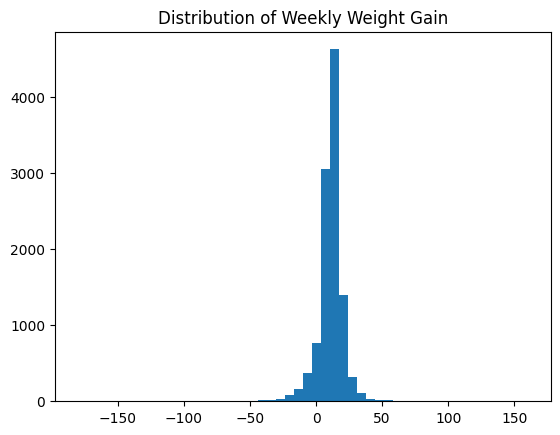

In [262]:
print(y.describe())
plt.hist(y, bins=50)
plt.title('Distribution of Weekly Weight Gain')
plt.show()


Split dataset

In [203]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Initialize and train model, evaluate result

In [226]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000]
}

xgb_r = xg.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=42)
grid_search = GridSearchCV(xgb_r, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 43.2575
R^2 Score: 0.6544


In [234]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

model = grid_search.best_estimator_

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Best Score: -58.09503381008339


In [220]:
xgb_r = xg.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=42)
xgb_r.fit(X_train, y_train)

y_train_pred = xgb_r.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Train Mean Squared Error: {mse_train:.4f}")
print(f"Train R^2 Score: {r2_train:.4f}")
print("")


y_pred = xgb_r.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Train Mean Squared Error: 3.7587
Train R^2 Score: 0.9718

Mean Squared Error: 51.4163
R^2 Score: 0.5892


In [237]:
imp = model.feature_importances_
feature_importances = pd.Series(imp, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(15) 

DailyFluidOutput_rolling_mean_squared_squared    0.088626
BW                                               0.084117
MeanDailyPulsePerKG_squared_squared              0.072853
DailyFluidIntake_squared_squared                 0.069863
SexMInt                                          0.068773
DailyFluidIntake_rolling_mean_squared_squared    0.057347
DailyFluidOutput_rolling_mean_squared            0.034321
DailyEnergy_squared_squared                      0.032076
PMADays                                          0.030347
Sex                                              0.027818
GA                                               0.026422
DailyFluidOutput_rolling_mean                    0.026380
DayFromBirthNumeric                              0.023623
DailyFluidIntake_rolling_mean                    0.023246
ID                                               0.021787
dtype: float32

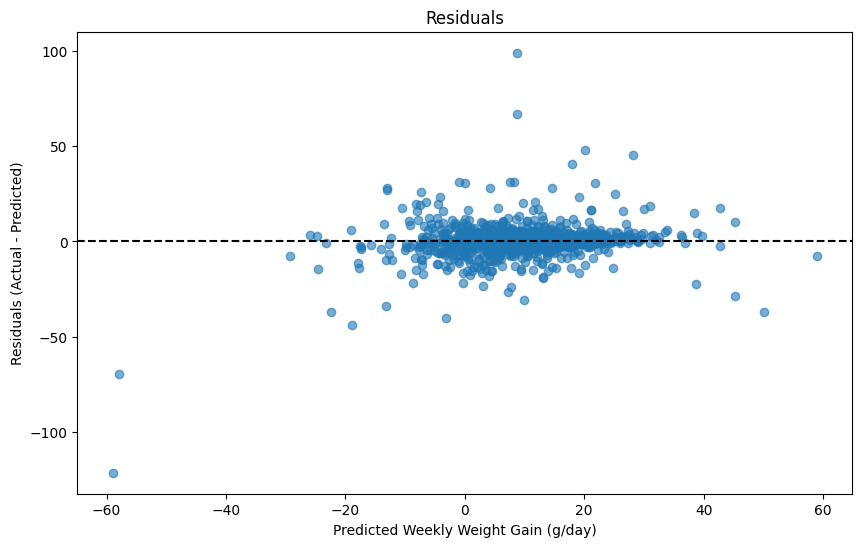

In [238]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Weekly Weight Gain (g/day)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals')
plt.show()


In [215]:
scores = cross_val_score(xgb_r, X_test, y_test, cv=10)
scores

print(f"Scores mean: {scores.mean()}")
print(f"Scores std: {scores.std()}")

Scores mean: 0.2870490069827575
Scores std: 0.17688748985803998
